In [1]:
%matplotlib inline

import matplotlib.pylab as plt
import seaborn as sns
from sigvisa import Sigvisa
import numpy as np

import scipy.stats
from sigvisa.database.signal_data import execute_and_return_id
from sigvisa.learn.train_param_common import insert_model
import os

from sigvisa.models.noise.noise_model import NoiseModel
from sigvisa.models.distributions import Gaussian, TruncatedGaussian, InvGamma, MultiGaussian, LogNormal
from sigvisa.utils.fileutils import mkdir_p

In [2]:


def noise_model_model_fname(runid, sta, band, chan, hz, env, n_p, param):
    prefix="parameters/runs/"
    s = Sigvisa()
    fdir = os.path.join(prefix, "noise_%d" % runid, sta, chan, band, "hz_%.2f" % hz)
    mkdir_p(os.path.join(s.homedir, fdir))
    env_s = "env" if env else "raw"
    fname = "%s_np%d_%s.pkl" % (param, n_p, env_s)
    return os.path.join(fdir, fname)

    
def fit_var_model(censored_vars, sta):
    
    # try invgamma
    fit_alpha, fit_loc, fit_beta = scipy.stats.invgamma.fit(censored_vars, floc=0.0)
    ig_model = InvGamma(alpha=fit_alpha, beta=fit_beta)
    ig_lp = np.sum([ig_model.log_p(v) for v in censored_vars])
    
    gmean, gstd = np.mean(censored_vars), np.std(censored_vars)
    norm_model = TruncatedGaussian(gmean, std=gstd, a=0.0)
    norm_lp = np.sum([norm_model.log_p(v) for v in censored_vars])
    
    mu, sigma = np.mean(np.log(censored_vars)), np.std(np.log(censored_vars))
    lognorm_model = LogNormal(mu, sigma)
    lognorm_lp = np.sum([lognorm_model.log_p(v) for v in censored_vars])
        
    if sta=="ELK":
        return lognorm_model, "lognormal", (mu, sigma)
        
        
    try:
        ig_model.variance()
    except:
        print "disallowing invgamma model with undefined variance"
        ig_lp = -np.inf
        
    print ig_lp, norm_lp, lognorm_lp
    if ig_lp > norm_lp and ig_lp > lognorm_lp:
        print "best model is invgamma"
        return ig_model, "invgamma", (fit_alpha,  fit_beta)
    elif norm_lp > lognorm_lp:
        print "best model is tgaussian"
        return norm_model, "tgaussian", (gmean, gstd)
    else:
        print "best model is lognormal"
        return lognorm_model, "lognormal", (mu, sigma)
    
def train_noise_mean_priors(runid, sta, band, hz, env, 
                            mean_upper_cutoff=None, mean_lower_cutoff=None, 
                            std_upper_cutoff = None,
                            chan=None, n_p=None, dummy=False,
                            insert_runid=None):

    if insert_runid is None:
        insert_runid = runid
    
    np_cond = ("and nm.n_p=%d" %n_p) if n_p is not None else ""
    fit_conds = "fit.runid=%d and fit.sta='%s' and fit.band='%s' and fit.chan='%s' and fit.hz=%f and fit.env='%s'" %\
                (runid, sta, band, chan, hz, 't' if env else 'f')
    sql_query = "select nm.fname from sigvisa_coda_fit fit, sigvisa_noise_model nm where nm.nmid = fit.nmid and %s %s" % (fit_conds, np_cond)
    s = Sigvisa()
    cursor = s.dbconn.cursor()
    
    cursor.execute(sql_query)
    fnames = cursor.fetchall()
    models = []
    for fname in fnames:
        try:
            model = NoiseModel.load_from_file(fname[0], "ar")
        except:
            continue
        models.append(model)
    
    if len(models) == 0:
        print "WARNING: no models found from query %s, skipping..." % sql_query
        return
    
    means = np.array([nm.c for nm in models])
    stds = np.array([nm.em.std for nm in models])
    params = [np.array(nm.params) for nm in models]
    
    n_ps = [len(p) for p in params]
    r = scipy.stats.mode(n_ps)    
    n_p = r.mode[0]
    params = np.array([ p for p in params if len(p)==n_p])
    
    means_cutoff = np.percentile(means, 90)
    if mean_upper_cutoff is not None:
        means_cutoff = min(mean_upper_cutoff, means_cutoff)
    stds_cutoff = np.percentile(stds, 90)
    if std_upper_cutoff is not None:
        stds_cutoff = min(std_upper_cutoff, stds_cutoff)
        

    censored_means = []
    censored_stds = []
    censored_params = []
    for nm in models:
        if len(nm.params) != n_p: continue
        if nm.c > means_cutoff: continue
        if nm.em.std > stds_cutoff: continue
        if mean_lower_cutoff is not None:
            if nm.c < mean_lower_cutoff: continue
            
        censored_means.append(nm.c)
        censored_stds.append(nm.em.std)
        censored_params.append(nm.params)
    censored_means = np.array(censored_means)
    censored_stds = np.array(censored_stds)
    censored_params = np.array(censored_params)
    
    nfits = len(censored_means)
    if nfits < 5:
        print "not enough fits for", sta
        print sql_query
        return

    
        
    
    plt.figure()
    
    sns.distplot(censored_means)
    fit_loc, fit_scale = scipy.stats.norm.fit(censored_means)
    if env:
        mean_model = TruncatedGaussian(fit_loc, std=fit_scale, a=0)
        mtype="tgaussian"
    else:
        mean_model = Gaussian(fit_loc, std=fit_scale)
        mtype="gaussian"
    xs = np.linspace(0, np.max(censored_means), 100)
    meanlps = np.array([np.exp(mean_model.log_p(x)) for x in xs])
    plt.plot(xs, meanlps)
    plt.title("%s means" % sta)
    
    if not dummy:
        phase_name = "noise_%s" % ("env" if env else "raw")
        mean_fname = noise_model_model_fname(runid, sta, band, chan, hz, env, n_p, "mean")
        mean_model.dump_to_file(os.path.join(s.homedir, mean_fname))
        insert_model(s.dbconn, insert_runid, "armean", sta, chan, band, phase_name, 
                     model_type=mtype, model_fname=mean_fname, training_set_fname="", 
                     training_ll=0.0, require_human_approved=False, max_acost=0.0, n_evids=nfits, 
                     min_amp=0.0, elapsed=0.0, hyperparams=repr((fit_loc, fit_scale)))
        print mean_fname
    
    
    plt.figure()
    censored_vars = censored_stds**2
    sns.distplot(censored_vars)
    var_model, var_model_type, var_hparams = fit_var_model(censored_vars, sta=sta)
    xs = np.linspace(0, np.max(censored_vars), 100)
    varlps = np.array([np.exp(var_model.log_p(x)) for x in xs])
    plt.plot(xs, varlps)
    plt.title("%s vars" % sta)
    
    if not dummy:
        var_fname = noise_model_model_fname(runid, sta, band, chan, hz, env, n_p, "arvar")
        var_model.dump_to_file(os.path.join(s.homedir, var_fname))
        insert_model(s.dbconn, insert_runid, "arvar", sta, chan, band, phase_name, 
                     model_type=var_model_type, model_fname=var_fname, training_set_fname="", 
                     training_ll=0.0, require_human_approved=False, max_acost=0.0, n_evids=nfits, 
                     min_amp=0.0, elapsed=0.0, hyperparams=repr(var_hparams))
        print var_fname
    
    
    mean_params = np.mean(censored_params, axis=0)
    param_cov = np.cov(censored_params.T) + np.eye(n_p) * 0.2
    param_model = MultiGaussian(mean_params, param_cov)
    print "params mean", mean_params
    print "params cov", param_cov
    
    if not dummy:
        param_fname = noise_model_model_fname(runid, sta, band, chan, hz, env, n_p, "arparams")
        param_model.dump_to_file(os.path.join(s.homedir, param_fname))
        insert_model(s.dbconn, insert_runid, "arparams", sta, chan, band, phase_name, 
                     model_type="multigaussian", model_fname=param_fname, training_set_fname="", 
                     training_ll=0.0, require_human_approved=False, max_acost=0.0, n_evids=nfits, 
                     min_amp=0.0, elapsed=0.0, hyperparams=repr((mean_params, param_cov)))
        print param_fname
    
    

    

# Training models for envelope signals

ANMO BHZ
parameters/runs/noise_19/ANMO/BHZ/freq_0.8_4.5/hz_2.00/mean_np1_env.pkl
disallowing invgamma model with undefined variance
-inf -3011.74962386 -3042.89097945
best model is tgaussian
parameters/runs/noise_19/ANMO/BHZ/freq_0.8_4.5/hz_2.00/arvar_np1_env.pkl
params mean [ 0.36902979]
params cov [[ 0.20949869]]
parameters/runs/noise_19/ANMO/BHZ/freq_0.8_4.5/hz_2.00/arparams_np1_env.pkl
ELK BHZ
parameters/runs/noise_19/ELK/BHZ/freq_0.8_4.5/hz_2.00/mean_np1_env.pkl
parameters/runs/noise_19/ELK/BHZ/freq_0.8_4.5/hz_2.00/arvar_np1_env.pkl
params mean [ 0.34278949]
params cov [[ 0.21139498]]
parameters/runs/noise_19/ELK/BHZ/freq_0.8_4.5/hz_2.00/arparams_np1_env.pkl
IL31 BHZ
parameters/runs/noise_19/IL31/BHZ/freq_0.8_4.5/hz_2.00/mean_np1_env.pkl
-1153.60079948 -1161.95876829 -1150.75023213
best model is lognormal
parameters/runs/noise_19/IL31/BHZ/freq_0.8_4.5/hz_2.00/arvar_np1_env.pkl
params mean [ 0.52769951]
params cov [[ 0.21052352]]
parameters/runs/noise_19/IL31/BHZ/freq_0.8_4.5/hz_2.

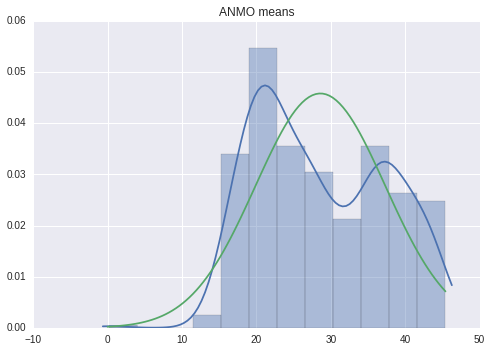

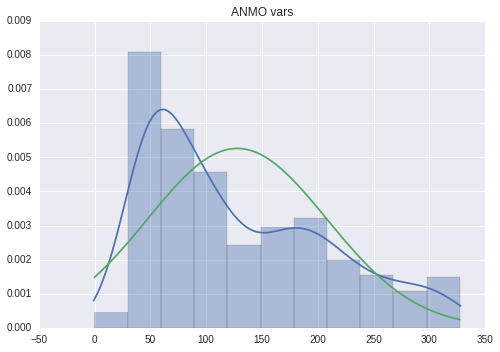

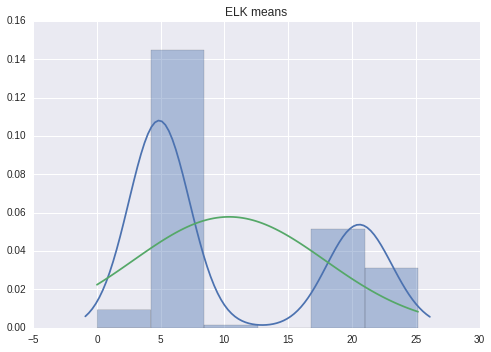

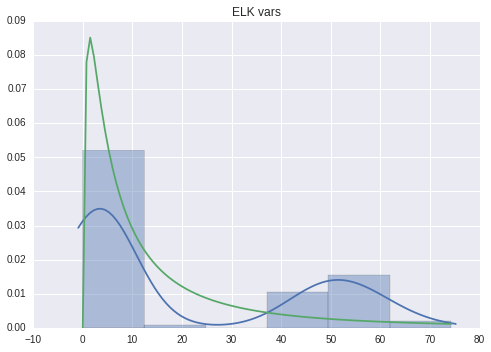

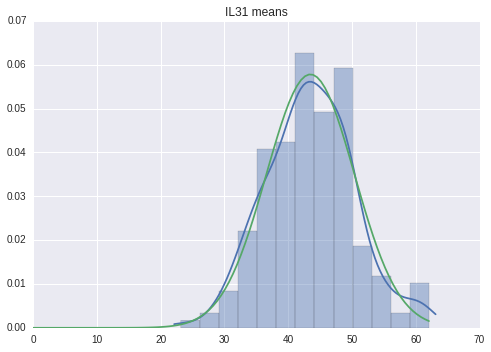

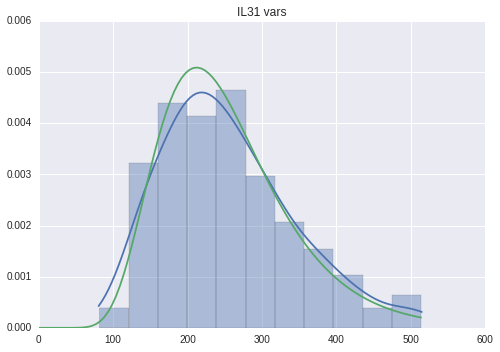

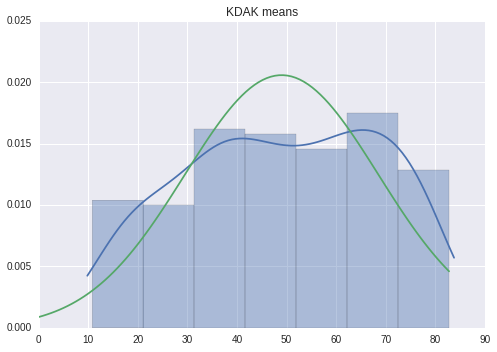

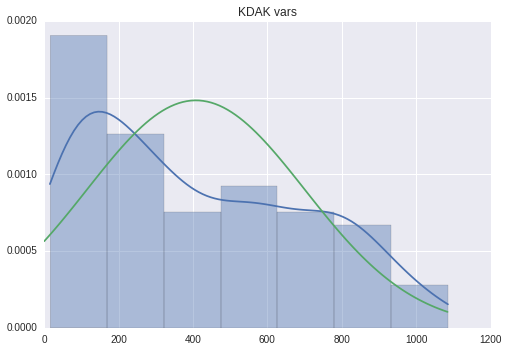

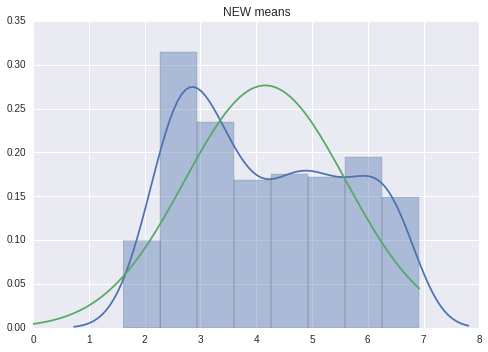

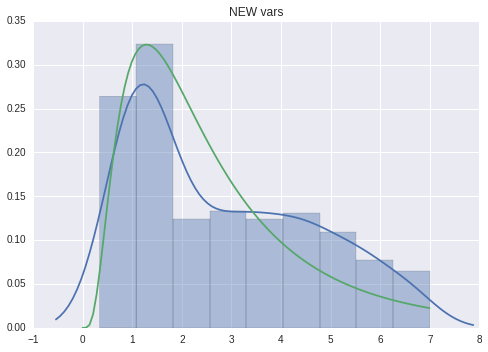

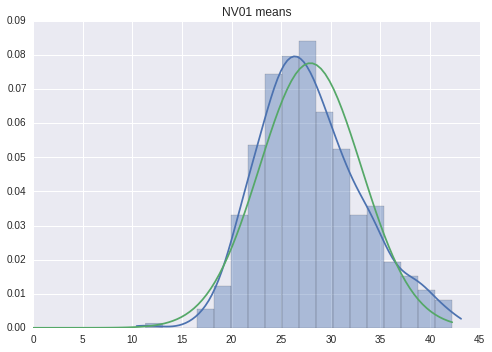

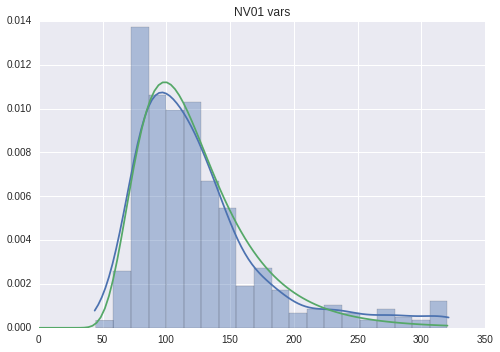

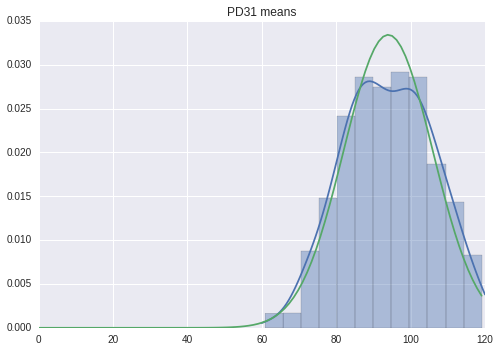

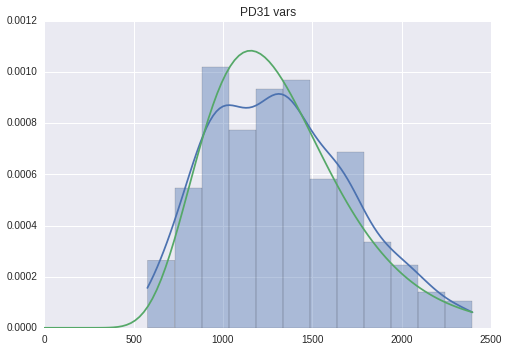

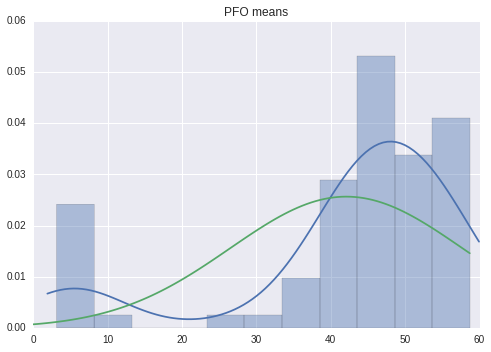

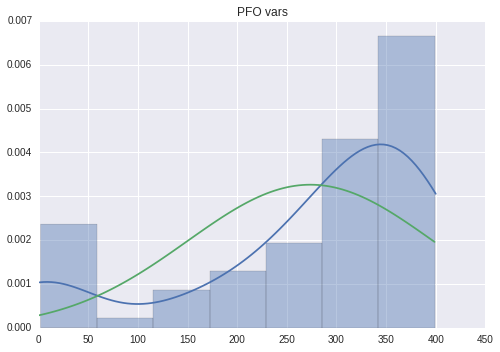

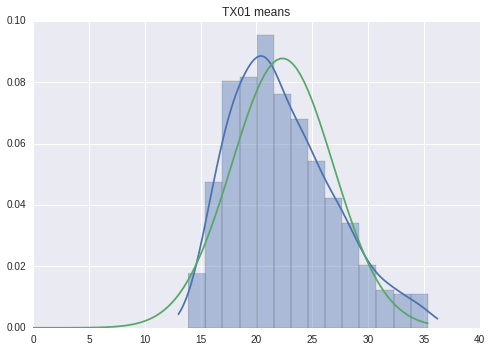

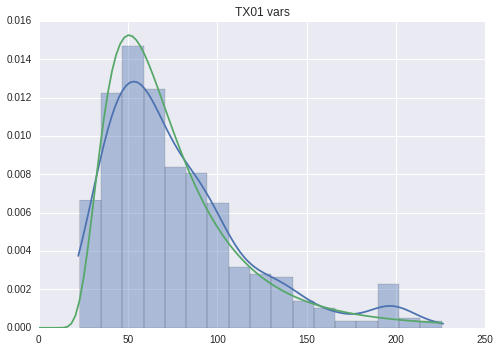

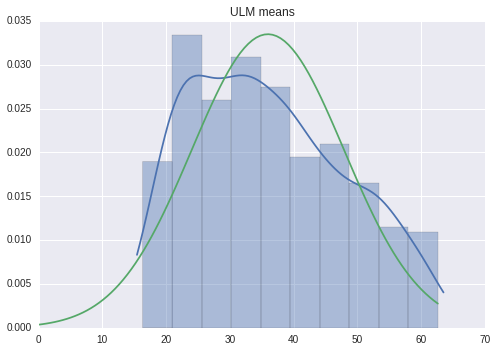

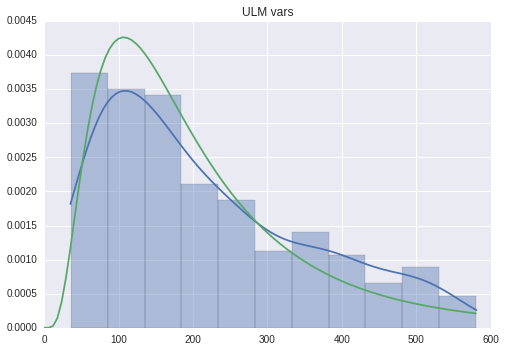

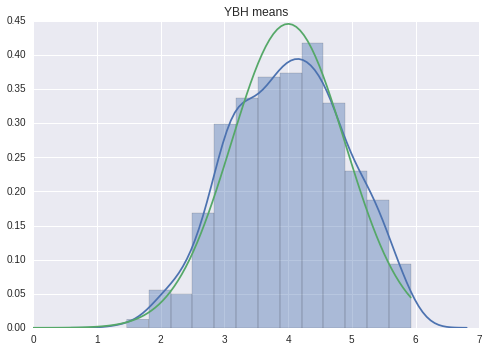

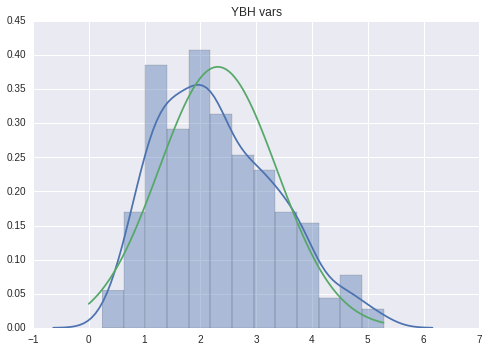

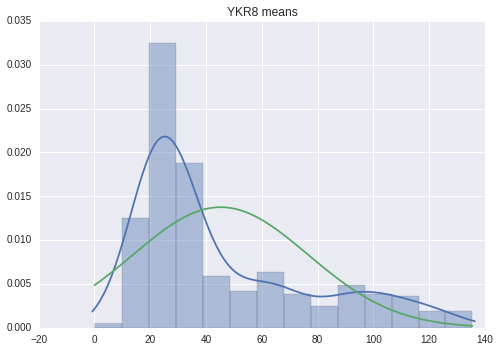

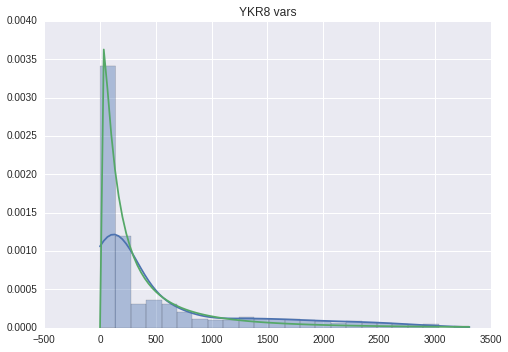

In [4]:


sites="ANMO,ELK,ILAR,KDAK,NEW,NVAR,PDAR,PFO,TXAR,ULM,YBH,YKA".split(",")
band="freq_0.8_4.5"
hz=2
env=True
llnl=True
for site in sites:
    sta = Sigvisa().get_default_sta(site)
    chan = Sigvisa().default_vertical_channel[sta]
    print sta, chan
    if chan=="sz":
        chan="SHZ"
    if chan=="bz":
        chan="BHZ"
    
    #if sta=="NEW":
    #    cutoff = 50
    #else:
    #    cutoff = None
    
    std_cutoff = None
    #if sta=="NV01":
    #    std_cutoff = 100.0
    if sta=="NV01":
        std_cutoff = 100.0
    elif sta=="PFO":
        std_cutoff=20.0
    elif sta=="YBH":
        std_cutoff=10.0
    elif sta=="TX01":
        std_cutoff=20.0
    elif sta=="PD31":
        std_cutoff=100.0
    elif sta=="IL31":
        std_cutoff=25.0
    elif sta=="ANMO":
        std_cutoff=30.0
    elif sta=="IL31":
        std_cutoff=25.0
    elif sta=="ELK":
        std_cutoff=12.0
    cutoff=None
    low_cutoff=None
        
    train_noise_mean_priors(runid=19, sta=sta, band="freq_0.8_4.5", chan=chan, hz=hz, 
                            env=env, mean_upper_cutoff=cutoff, std_upper_cutoff=std_cutoff,
                            mean_lower_cutoff=low_cutoff, dummy=False)

# Training models for raw waveforms

ANMO BHZ
parameters/runs/noise_18/ANMO/BHZ/freq_0.8_4.5/hz_10.00/mean_np4_raw.pkl
disallowing invgamma model with undefined variance
-inf -4307.71097311 -4589.06124898
best model is tgaussian
parameters/runs/noise_18/ANMO/BHZ/freq_0.8_4.5/hz_10.00/arvar_np4_raw.pkl
params mean [ 0.26069117 -0.24235069 -0.02882699 -0.22351653]
params cov [[  2.05858019e-01   1.25626806e-03  -1.52686572e-03  -6.51888557e-04]
 [  1.25626806e-03   2.06252460e-01   9.10523471e-05  -1.10903369e-03]
 [ -1.52686572e-03   9.10523471e-05   2.04690286e-01  -1.47422848e-03]
 [ -6.51888557e-04  -1.10903369e-03  -1.47422848e-03   2.05120077e-01]]
parameters/runs/noise_18/ANMO/BHZ/freq_0.8_4.5/hz_10.00/arparams_np4_raw.pkl
ELK BHZ
parameters/runs/noise_18/ELK/BHZ/freq_0.8_4.5/hz_10.00/mean_np4_raw.pkl
parameters/runs/noise_18/ELK/BHZ/freq_0.8_4.5/hz_10.00/arvar_np4_raw.pkl
params mean [ 0.2106291  -0.24837994 -0.02870823 -0.17967761]
params cov [[ 0.20695472  0.00208449 -0.00219862 -0.00180198]
 [ 0.00208449  0.20603

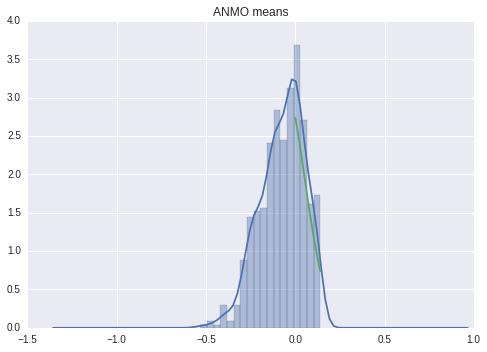

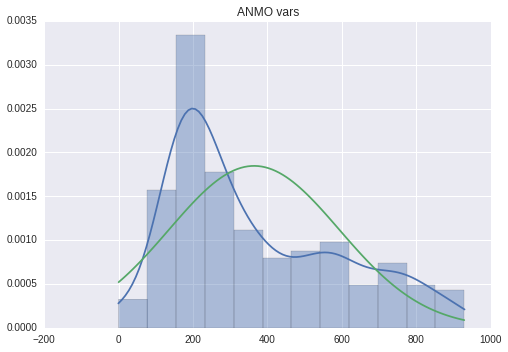

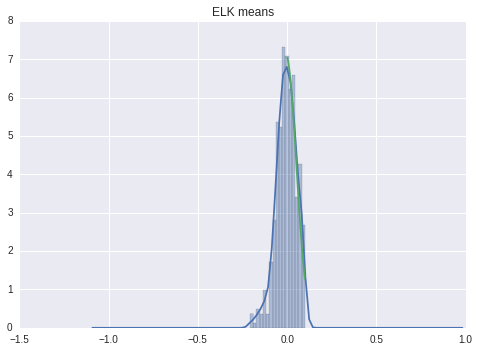

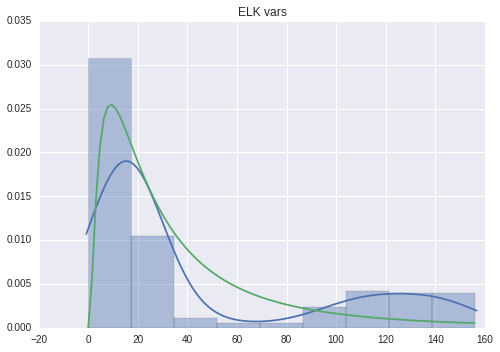

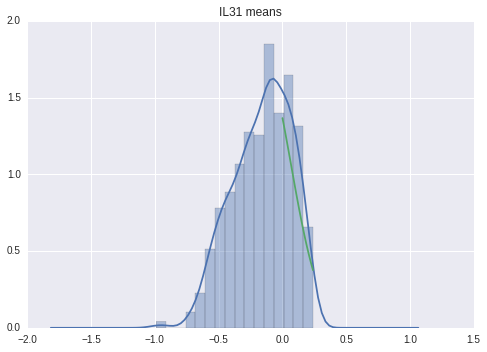

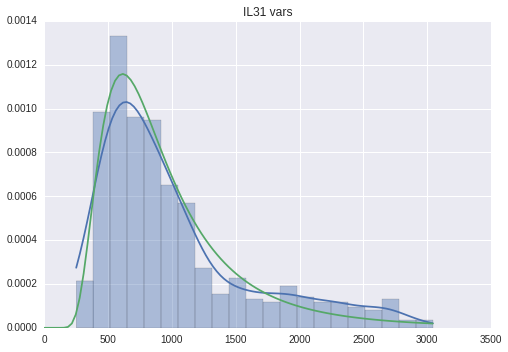

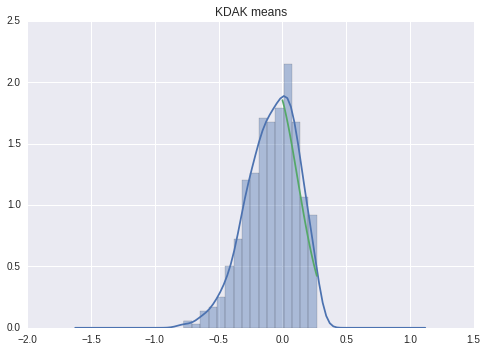

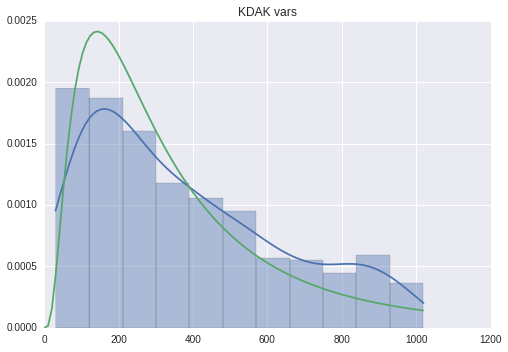

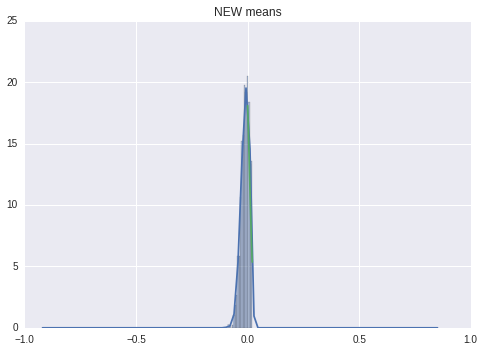

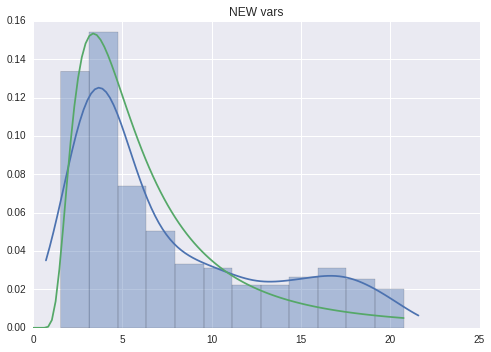

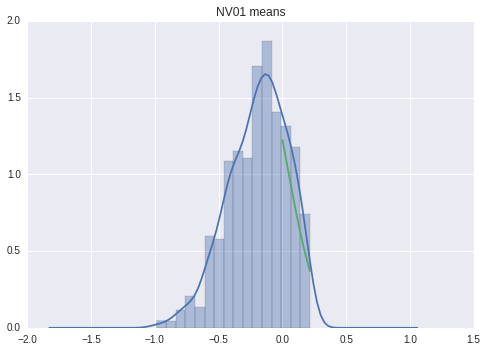

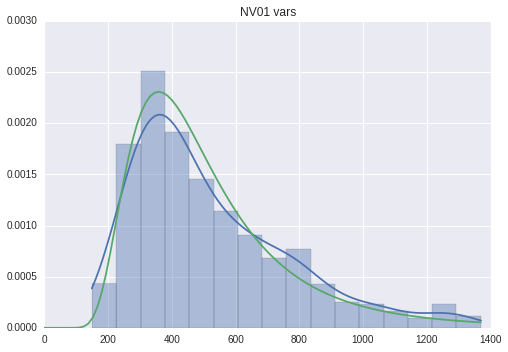

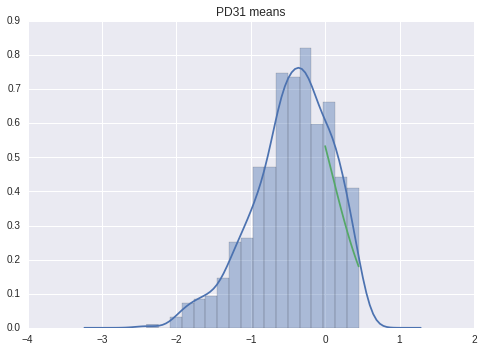

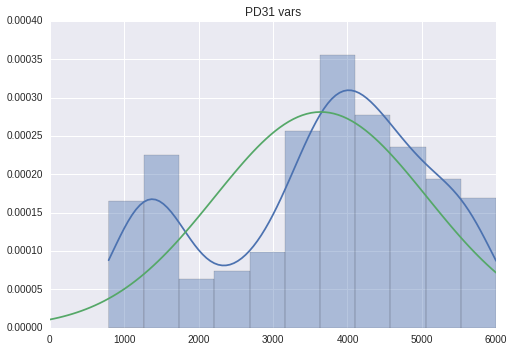

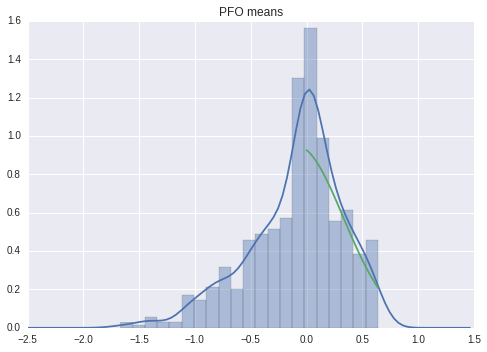

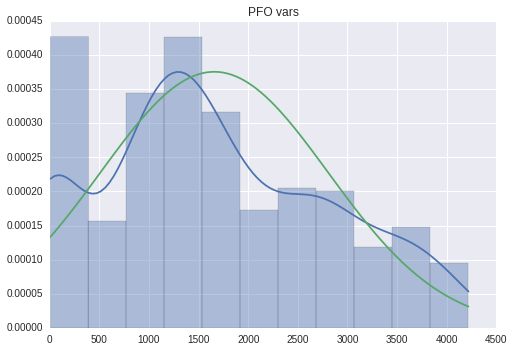

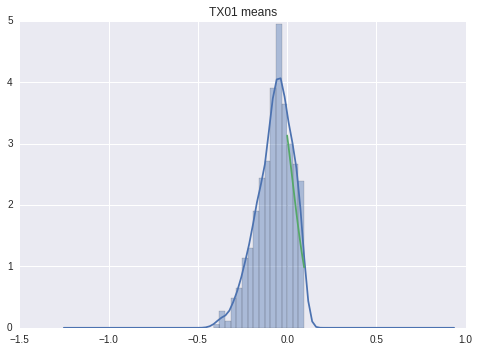

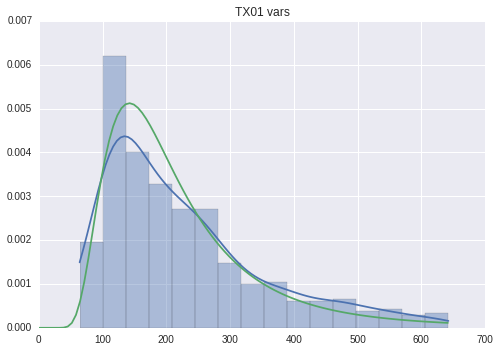

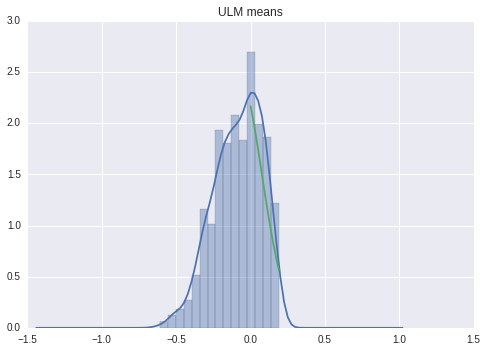

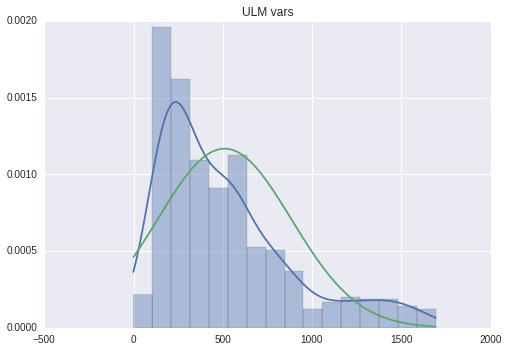

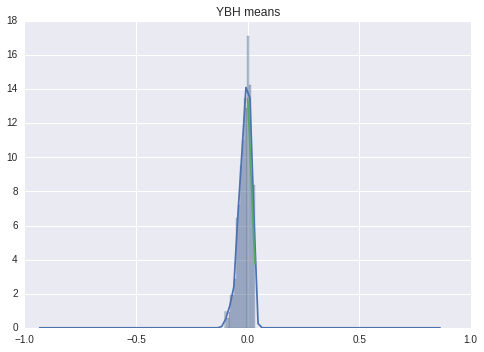

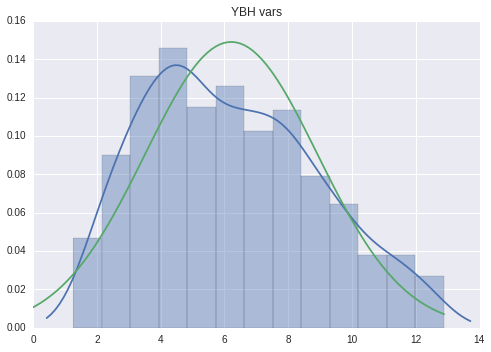

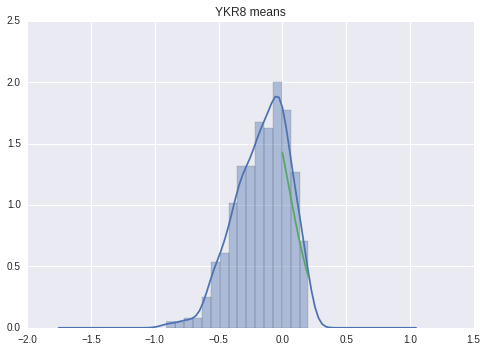

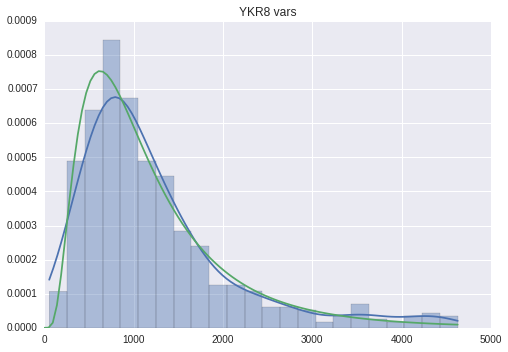

In [7]:


sites="ANMO,ELK,ILAR,KDAK,NEW,NVAR,PDAR,PFO,TXAR,ULM,YBH,YKA".split(",")
band="freq_0.8_4.5"
hz=10
env=False
llnl=True
#sites=["NV01",]
for site in sites:
    sta = Sigvisa().get_default_sta(site)
    chan = Sigvisa().default_vertical_channel[sta]
    print sta, chan
    if chan=="sz":
        chan="SHZ"
    if chan=="bz":
        chan="BHZ"
    
    std_cutoff=None
    if sta=="PD31":
        std_cutoff = 120
    elif sta=="YRK8":
        std_cutoff = 20

    
    cutoff=None
    low_cutoff=None
        
    train_noise_mean_priors(runid=18, sta=sta, band="freq_0.8_4.5", chan=chan, hz=hz, 
                            env=env, mean_upper_cutoff=cutoff, std_upper_cutoff=std_cutoff,
                            mean_lower_cutoff=low_cutoff, dummy=False, insert_runid=None)

# Investigating scaling differences in LLNL signal data

In [4]:

def plot_levels(sta, runid):
    s = Sigvisa()
    query = "select fp.arrival_time, fp.amp_transfer from sigvisa_coda_fit f, sigvisa_coda_fit_phase fp where f.sta='%s' and f.runid=%d and fp.phase='P' and fp.fitid=f.fitid"% (sta, runid)
    r = s.sql(query)
    r = np.array(r)
    plt.figure()
    plt.scatter(r[:, 0], r[:, 1])
    plt.title("%s amp_transfer" % sta)


    stime = np.min(r[:, 0])
    etime = np.max(r[:, 0])
    query = "select window_stime, mean from sigvisa_noise_model where window_stime between %f and %f and band='freq_0.8_4.5' and sta='%s' and hz=2.0 and env='t'" % (stime, etime, sta)
    r2 = np.array(s.sql(query))
    plt.figure()
    plt.scatter(r2[:, 0], r2[:, 1])
    plt.ylim([0, np.percentile(r2[:, 1], 99)])
    plt.title("%s noise means" % sta)
    
    return r, r2

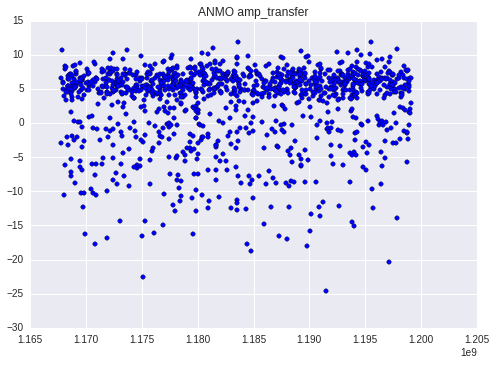

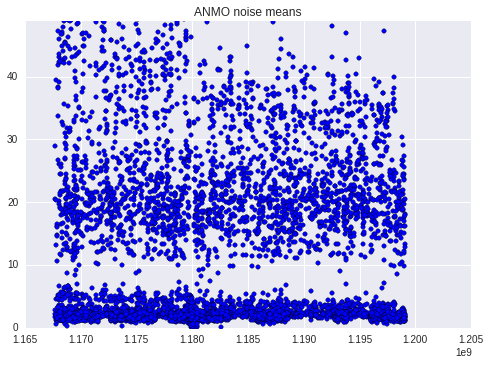

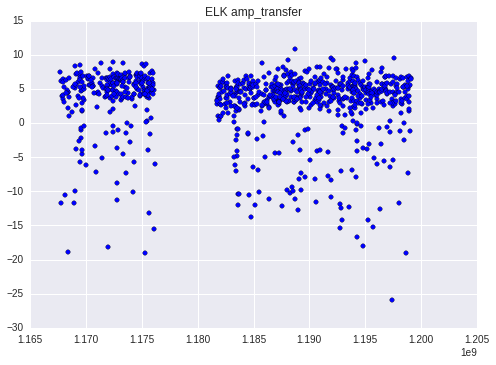

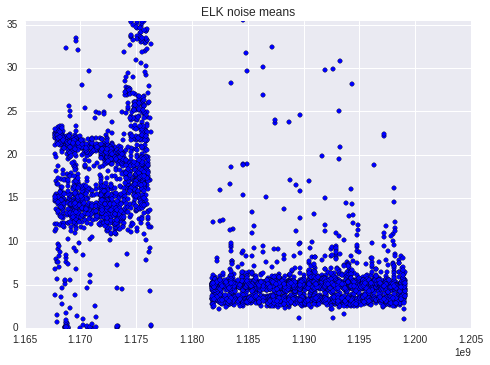

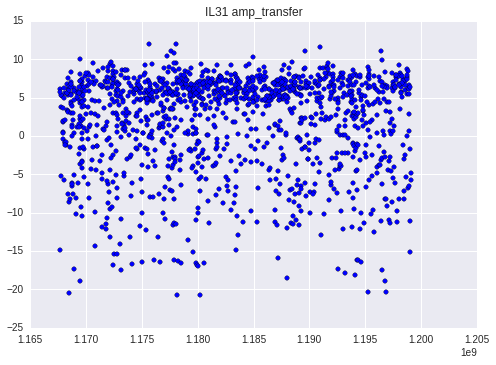

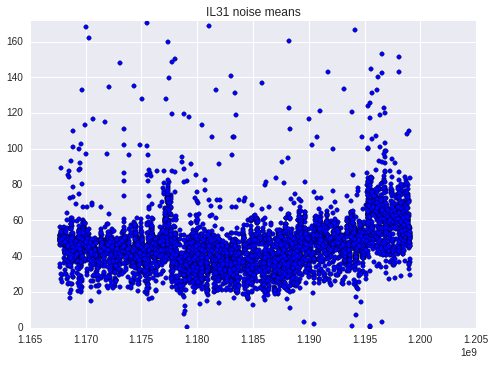

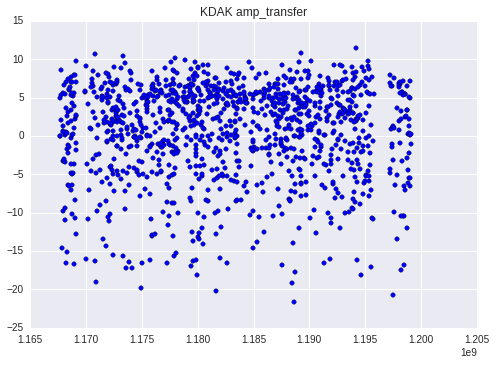

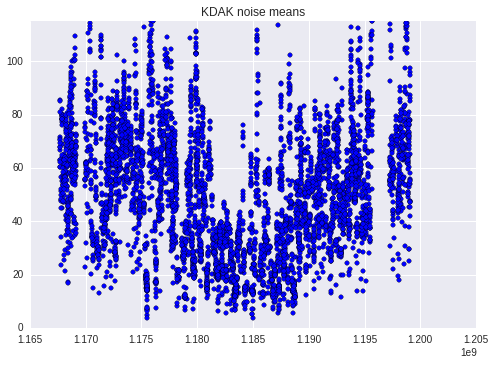

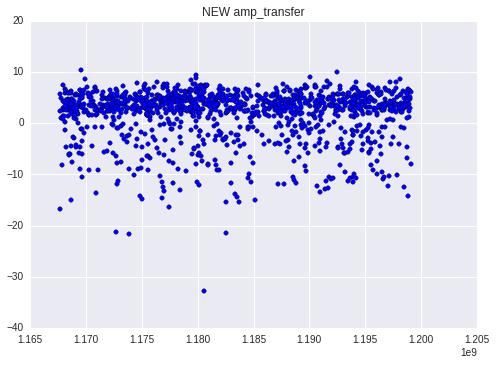

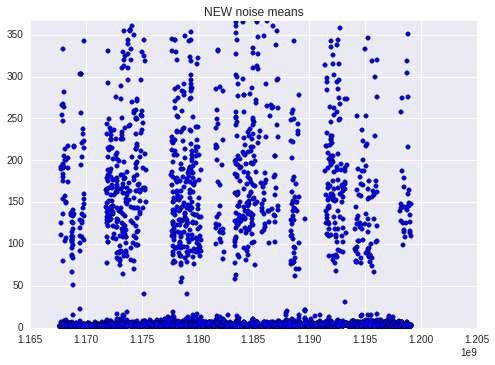

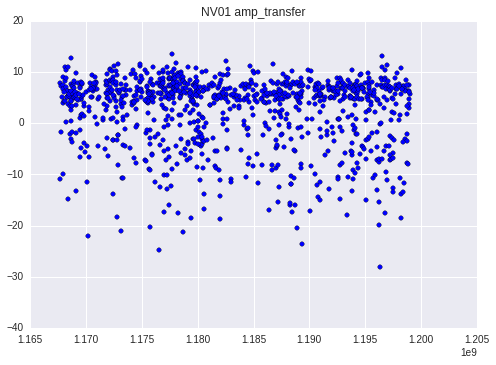

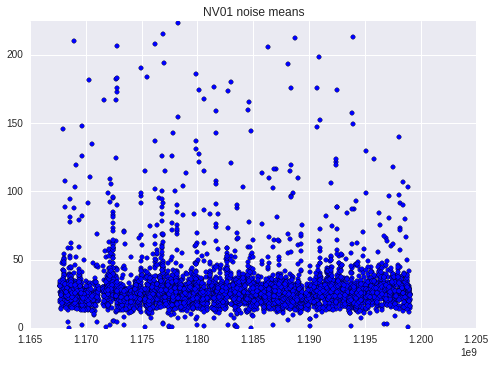

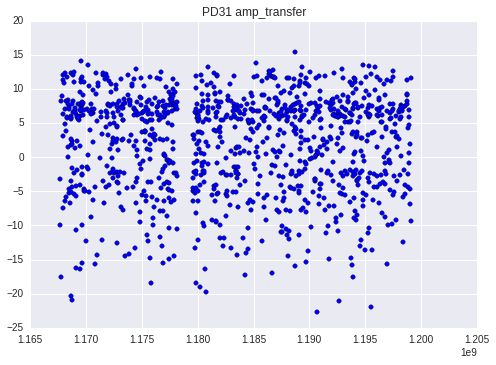

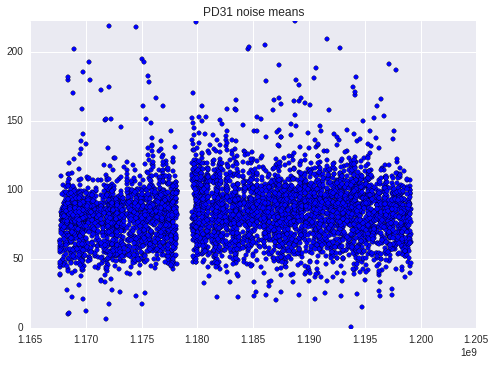

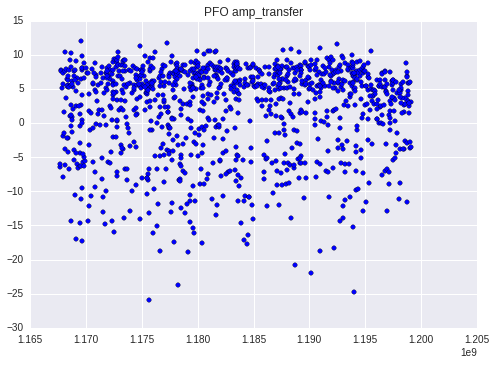

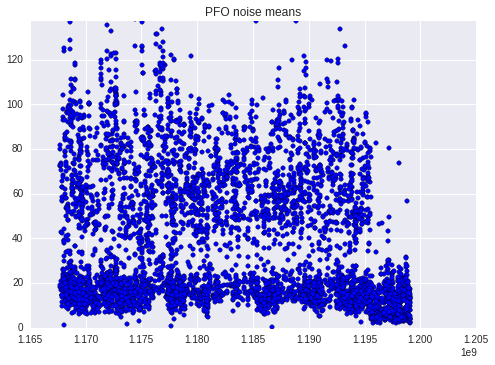

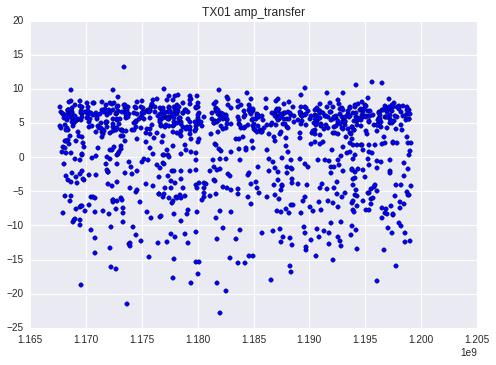

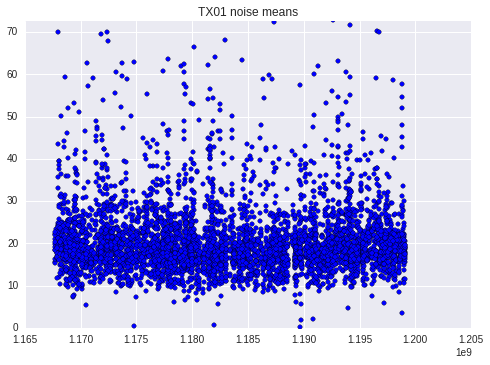

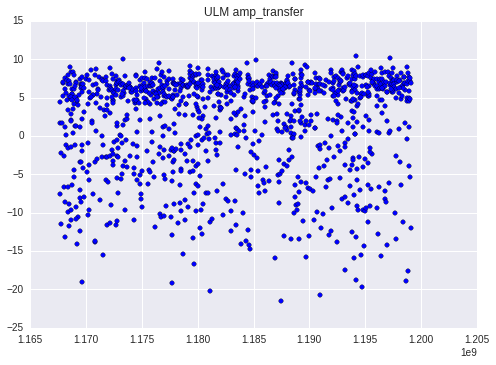

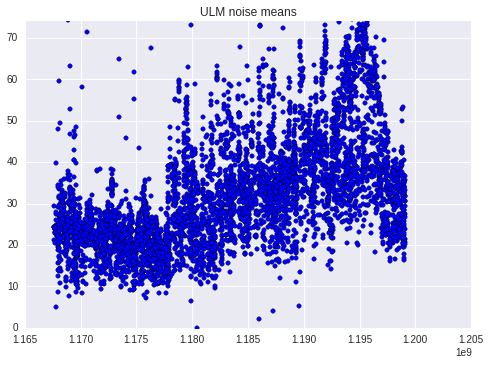

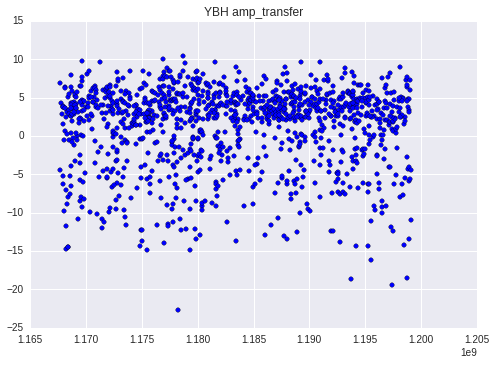

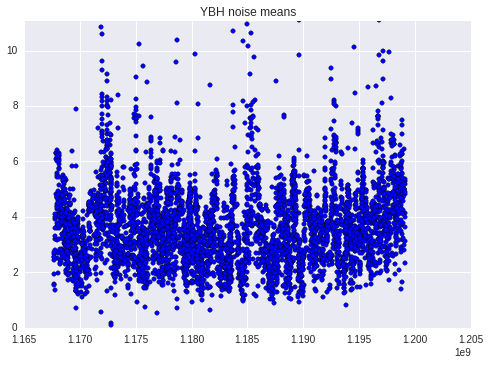

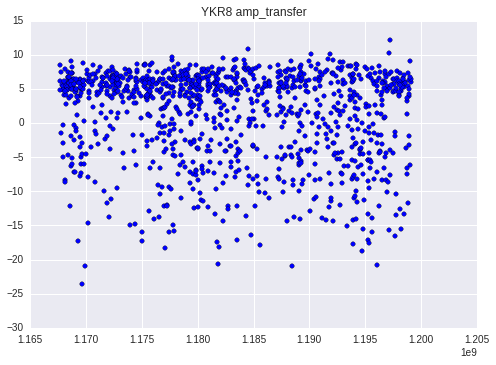

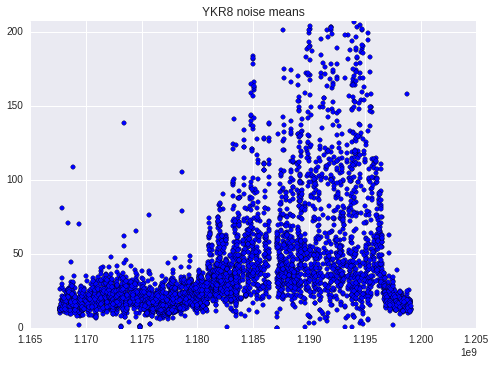

In [6]:
sites="ANMO,ELK,ILAR,KDAK,NEW,NVAR,PDAR,PFO,TXAR,ULM,YBH,YKA".split(",")
for site in sites:
    sta = Sigvisa().get_default_sta(site)
    plot_levels(sta, runid=10)

It definitely looks like there are two scales of signal, trading off in contiguous periods of varying length. Argh this is annoying. 

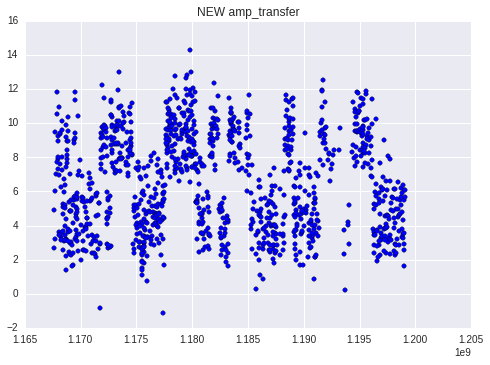

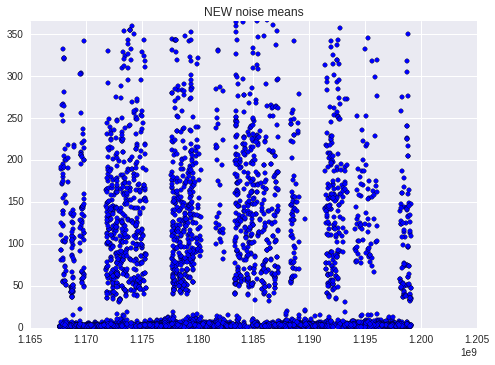

In [37]:
r, r2 = plot_levels("NEW")

(0, 366.2238154500003)

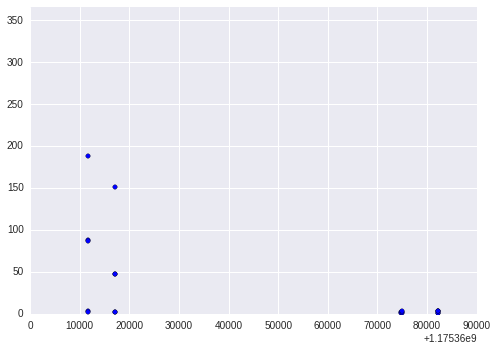

In [66]:
plt.scatter(r2[:, 0], r2[:, 1])
plt.xlim([1175360000, 1175450000])
plt.ylim([0, np.percentile(r2[:, 1], 99)])

In [4]:
from sigvisa.signals.io import fetch_waveform

In [5]:
#w = fetch_waveform(station="NEW", chan="BHZ", stime=1174800000, etime=1175200000) #small
#w2 = fetch_waveform(station="NEW", chan="BHZ", stime=1194622932, etime=1194623376) # large
#w3 = fetch_waveform(station="NEW", chan="BHZ", stime=1190000000, etime=1190100000) # small
#w3 = fetch_waveform(station="NEW", chan="BHZ", stime=1192000000, etime=1192100000) # large?

w3 = fetch_waveform(station="NEW", chan="BHZ", stime=1191422000, etime=1191423000)

print w3["stime"], w3["etime"]

[('BHZ', 1191196800.0, 1191422872.5, 40.0, 9042901L, 'NEW/sac2007001-2008091', '2007.274.00.00.00.0000.US.NEW..BHZ.M.SAC'), ('BHZ', 1191332381.525001, 1191422567.500001, 40.0, 3607440L, 'NEW/sac2007001-2008091', '2007.275.13.39.41.5250.US.NEW.HR.BHZ.M.SAC'), ('BHZ', 1191422652.45, 1193410830.775, 40.0, 79527134L, 'NEW/sac2007001-2008091', '2007.276.14.44.12.4500.US.NEW.HR.BHZ.M.SAC'), ('BHZ', 1191422883.525, 1192665385.0, 40.0, 49700060L, 'NEW/sac2007001-2008091', '2007.276.14.48.03.5250.US.NEW..BHZ.M.SAC')]
1191421980 1191423020.0


(-1500, 1500)

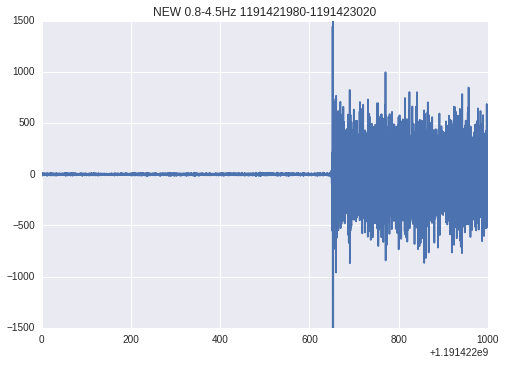

In [142]:
wf = w3.filter("freq_0.8_4.5")
t = np.linspace(w3["stime"], w3["etime"], len(w3.data))
plt.plot(t, wf.data)
plt.title("NEW 0.8-4.5Hz %.0f-%.0f" % (w3["stime"], w3["etime"]))
plt.ylim([-1500, 1500])

In [10]:
s = Sigvisa()
sql = "select chan, stime, etime, hz, npts, subdir, fname from llnl_wfdisc where sta = '%s' and chan='BHZ' and stime < %f and etime > %f and hz > 9.0 " % (
    "NEW", 1191423000, 1191422000)

waveforms = s.sql(sql)
print waveforms



(('BHZ', 1191196800.0, 1191422872.5, 40.0, 9042901L, 'NEW/sac2007001-2008091', '2007.274.00.00.00.0000.US.NEW..BHZ.M.SAC'), ('BHZ', 1191422652.45, 1193410830.775, 40.0, 79527134L, 'NEW/sac2007001-2008091', '2007.276.14.44.12.4500.US.NEW.HR.BHZ.M.SAC'), ('BHZ', 1191422883.525, 1192665385.0, 40.0, 49700060L, 'NEW/sac2007001-2008091', '2007.276.14.48.03.5250.US.NEW..BHZ.M.SAC'), ('BHZ', 1191332381.525001, 1191422567.500001, 40.0, 3607440L, 'NEW/sac2007001-2008091', '2007.275.13.39.41.5250.US.NEW.HR.BHZ.M.SAC'))


6.29145e+08
3.35544e+10
6.29145e+08
3.35544e+10


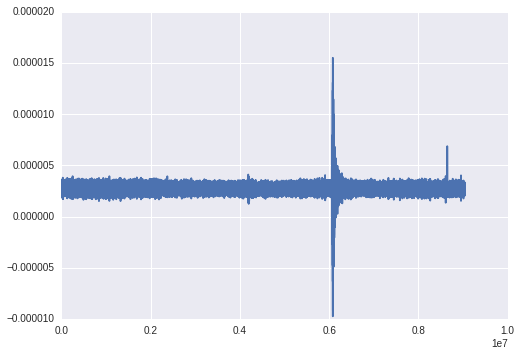

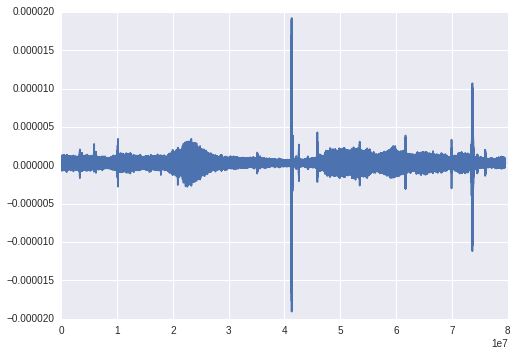

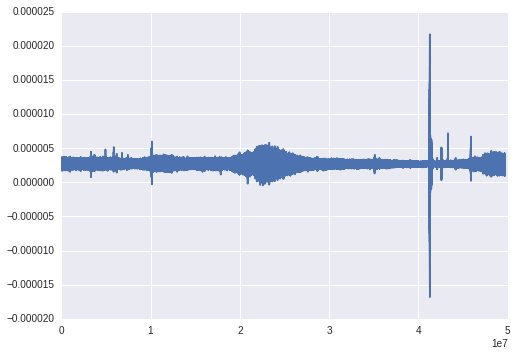

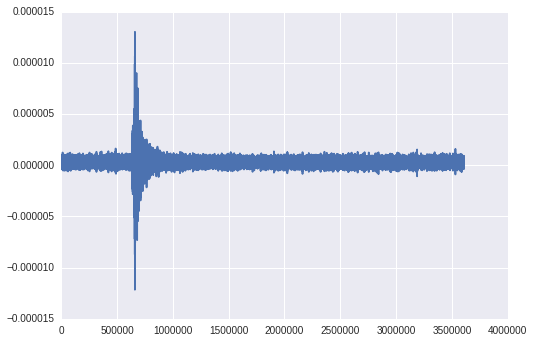

In [21]:
import obspy
import os
base_dir = os.path.join("/media/usb0/ctbt/llnl_data/")
for (chan, wave_stime, wave_etime, wave_hz, wave_npts, subdir, fname) in waveforms:
    fullpath = os.path.join(base_dir, subdir, fname)

    st = obspy.read(fullpath)
    print st[0].stats["calib"]
    plt.figure()
    plt.plot(st[0].data / st[0].stats["calib"])

In [18]:
print st[0].stats

         network: US
         station: NEW
        location: 
         channel: BHZ
       starttime: 2007-10-01T00:00:00.000000Z
         endtime: 2007-10-03T14:47:52.500000Z
   sampling_rate: 40.0
           delta: 0.025
            npts: 9042901
           calib: 6.29145e+08
         _format: SAC
             sac: AttribDict({u'dist': -12345.0, u'isynth': -12345, u'depmin': -12345.0, u'iftype': 1, u'kuser0': u'-12345  ', u'kuser1': u'-12345  ', u'kuser2': u'-12345  ', u'gcarc': -12345.0, u'iinst': -12345, u'ymaximum': -12345.0, u'kevnm': u'-12345          ', u'iqual': -12345, u'unused13': 0, u'cmpinc': 0.0, u'imagsrc': -12345, u'norid': 0, u'unused11': -12345.0, u'unused10': -12345.0, u'lpspol': 0, u'unused12': -12345.0, u'leven': 1, u't8': -12345.0, u't9': -12345.0, u't6': -12345.0, u't7': -12345.0, u't4': -12345.0, u't5': -12345.0, u't2': -12345.0, u't3': -12345.0, u't0': -12345.0, u't1': -12345.0, u'istreg': -12345, u'baz': -12345.0, u'yminimum': -12345.0, u'evla': -12345.0, u'xm

In [9]:
import obspy
s = Sigvisa()
cursor = s.dbconn.cursor()
r = s.sql("select id, subdir, fname from llnl_wfdisc")
n = len(r)
base_dir = os.path.join("/media/usb0/ctbt/llnl_data/")
for i, (wid, subdir, fname) in enumerate(r):
    fullpath = os.path.join(base_dir, subdir, fname)
    st = obspy.read(fullpath, headonly=True)
    calib = st[0].stats["calib"]    
    cursor.execute("update llnl_wfdisc set calib=%f where id=%d" % (calib, wid))
    if i % 1000 == 0:
        print "%d/%d: " % (i, n), fname, calib
cursor.close()
s.dbconn.commit()

0/149100:  2008.091.11.58.38.0550.II.PFO.00.ENZ.M.SAC 550425.0
1000/149100:  2007.147.02.51.42.9949.II.PFO.00.LHE.M.SAC 1.2955e+10
2000/149100:  2007.260.15.25.20.0000.IM.NV01..SHZ.M.SAC 9.22659e+09
3000/149100:  2007.345.14.20.30.0000.IM.NV31..BHZ.M.SAC 1.57286e+10
4000/149100:  2007.253.16.18.20.0000.IM.NV31..BHE.M.SAC 1.57286e+10
5000/149100:  2007.340.07.33.50.0000.IM.NV31..BHE.M.SAC 1.57286e+10
6000/149100:  2007.155.13.45.40.0000.IM.NV31..BHE.M.SAC 1.57286e+10
7000/149100:  2007.039.17.41.34.0000.IM.NV31..BHN.M.SAC 1.57286e+10
8000/149100:  2007.012.02.25.24.0000.IM.NV31..BHN.M.SAC 1.57286e+10
9000/149100:  2007.007.17.06.28.0000.IM.NV31..BHZ.M.SAC 1.57286e+10
10000/149100:  2007.156.04.43.00.0000.IM.NV01..SHZ.M.SAC 9.22659e+09
11000/149100:  2007.101.10.09.20.0000.IM.NV01..SHZ.M.SAC 9.22659e+09
12000/149100:  2007.101.10.37.18.0000.IM.NV31..BHZ.M.SAC 1.57286e+10
13000/149100:  2007.076.21.50.10.0000.IM.NV31..BHZ.M.SAC 1.57286e+10
14000/149100:  2007.100.22.00.45.0000.IM.NV01..SH

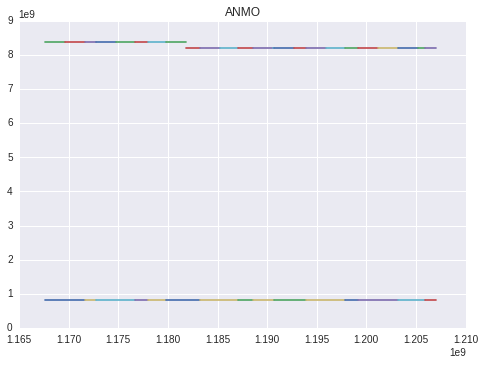

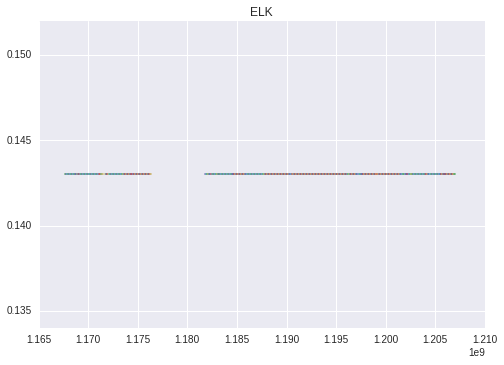

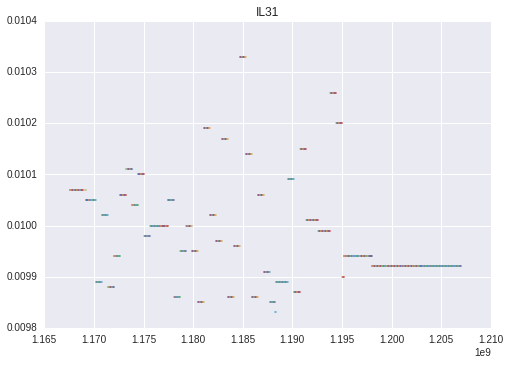

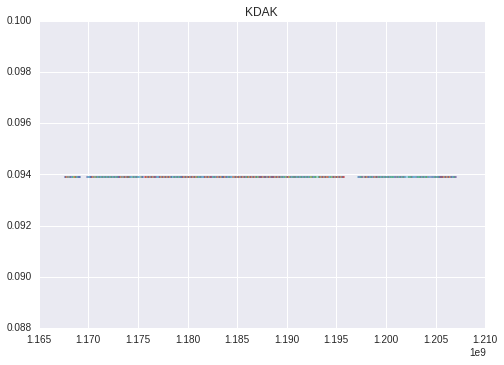

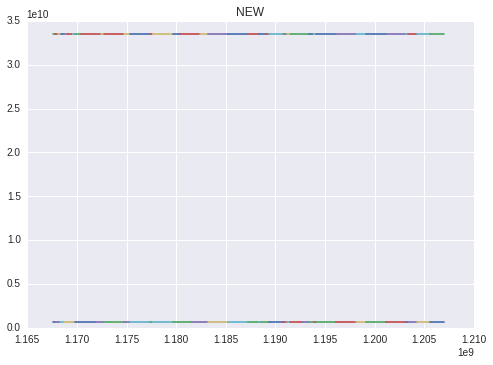

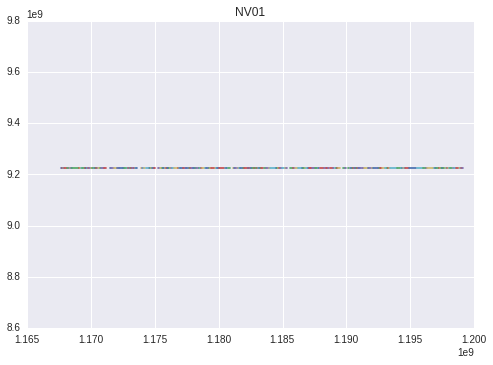

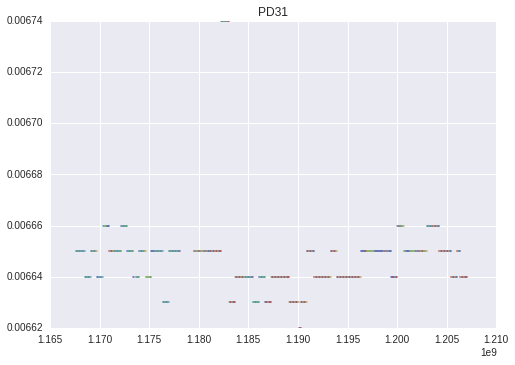

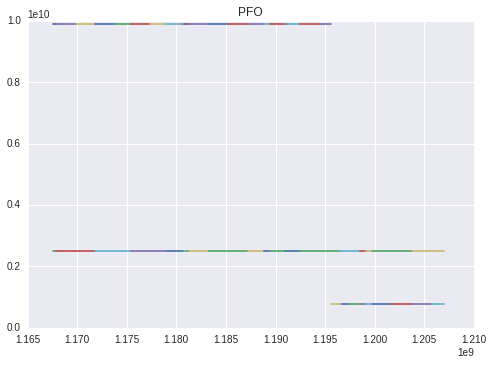

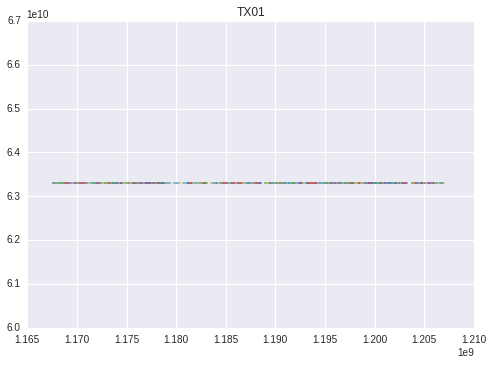

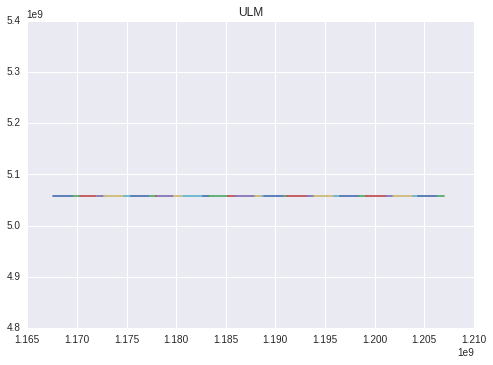

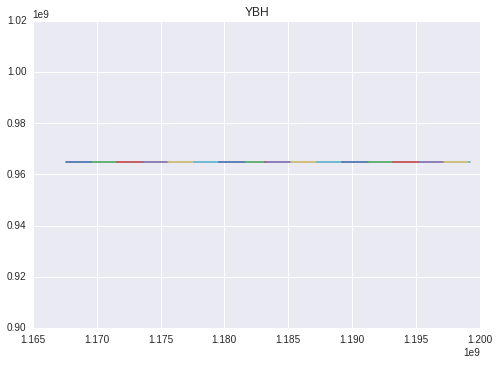

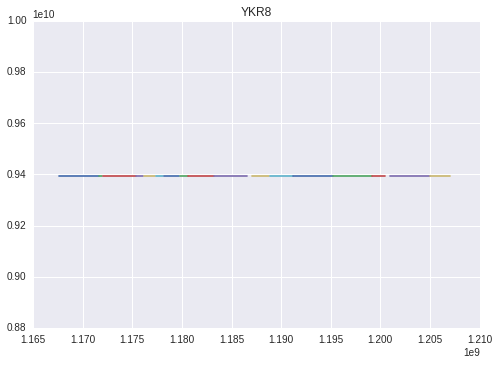

In [28]:
sites="ANMO,ELK,ILAR,KDAK,NEW,NVAR,PDAR,PFO,TXAR,ULM,YBH,YKA".split(",")
for site in sites:
    sta = Sigvisa().get_default_sta(site)

    plt.figure()
    r = s.sql("select stime, etime, calib, fname from llnl_wfdisc where sta='%s' and (chan='BHZ' or chan='SHZ') order by stime" % sta)
    for (stime, etime, calib, fname) in r:
        plt.plot((stime, etime), (calib, calib))
    plt.title(sta)
